### 📌 Disclaimer (Don't Judge)

##### I was just learning

- This project is a first attempt at building a multi-agent system and is intended solely for learning and experimentation purposes.

- It may not follow best practices, contain bugs, or be optimized for performance, security, or scalability.
- The architecture, code structure, and design choices reflect a work-in-progress approach as I explore the capabilities of agent-based systems using LangGraph and LangChain.

## Load the LLM model and wrap in pipeline

In [10]:
from transformers import pipeline
from langchain_huggingface.llms import HuggingFacePipeline

LLM_MODEL_ID = "google/flan-t5-base"  

pipe = pipeline(
    "text2text-generation",
    model=LLM_MODEL_ID,
    tokenizer=LLM_MODEL_ID,
    max_new_tokens=256,     # Reduced max_new_tokens for conciseness
    # temperature=0.1,       # Lower temperature for less randomness and more factual answers
    do_sample=False,
    device = -1             # set to -1 if no GPU available
)
llm = HuggingFacePipeline(pipeline=pipe)


Device set to use cpu


## Functions to use in agents

In [15]:
def find_events(city: str) -> str:
    """
    Find and return a list of events happening in the specified city.

    Args:
        city (str): The name of the city to lookup events for.

    Returns:
        str: A string describing events occurring in the city.
    """
    return f"Events in {city}: Concert, Art Exhibition, Food Festival."

def get_weather(city: str) -> str:
    """
    Retrieve the weather forecast for the specified city.

    Args:
        city (str): The name of the city to get the weather forecast for.

    Returns:
        str: A string describing the weather forecast in the city.
    """
    return f"The weather in {city} will be sunny with a high of 30°C."

def combine_info_with_llm(events: str, weather: str) -> str:
    prompt = (
        f"Here are some events: {events}\n"
        f"And here is the weather forecast: {weather}\n"
        f"Please provide a friendly recommendation combining both."
    )
    result = llm.invoke(prompt)
    # print(f"Result: {result}")
    if isinstance(result, dict):
        return result.get("text", "").strip()
    return str(result).strip()

## Manual Agent creation without LangGraph

In [16]:
from transformers import pipeline
from langchain_huggingface.llms import HuggingFacePipeline


# Manual multi-agent workflow function
def multi_agent_workflow(user_query: str) -> str:
    city = None
    if "in" in user_query:
        city = user_query.split("in")[-1].strip(" .?")
    if not city:
        return "Could not determine the city from your query."

    # Agent 1: find events
    events = find_events(city)
    # print(f"Events: {events}")

    # Agent 2: get weather
    weather = get_weather(city)
    # print(f"Weather: {weather}")

    # Agent 3: combine info via LLM
    recommendation = combine_info_with_llm(events, weather)

    return recommendation

# Example usage
query = "Find events and weather in San Francisco."
response = multi_agent_workflow(query)
print(response)


The weather in San Francisco will be sunny with a high of 30°C.


## Agent creation using LangGraph

In [17]:
from typing import TypedDict

class WorkflowState(TypedDict, total=False):
    user_query: str
    city: str
    events: str
    weather: str
    recommendation: str


In [18]:
def agent1_find_city(state: WorkflowState) -> WorkflowState:
    query = state.get("user_query", "")
    city = None
    if "in" in query:
        city = query.split("in")[-1].strip(" .?")
    state["city"] = city or ""
    return state

def agent2_find_events(state: WorkflowState) -> WorkflowState:
    city = state.get("city", "")
    if city:
        state["events"] = find_events(city)
    else:
        state["events"] = "No city provided."
    return state

def agent3_find_weather(state: WorkflowState) -> WorkflowState:
    city = state.get("city", "")
    if city:
        state["weather"] = get_weather(city)
    else:
        state["weather"] = "No city provided."
    return state

def agent4_combine(state: WorkflowState) -> WorkflowState:
    events = state.get("events", "")
    weather = state.get("weather", "")
    prompt = (
        f"Here are some events: {events}\n"
        f"And here is the weather forecast: {weather}\n"
        f"Please provide a friendly recommendation combining both."
    )
    llm_output = llm.invoke(prompt)
    if isinstance(llm_output, dict):
        llm_output = llm_output.get("text", "")
    state["recommendation"] = llm_output.strip()
    return state


In [19]:
from langgraph.graph import StateGraph, MessagesState, START, END

# Instantiate a state graph with the WorkflowState as the state
graph_builder = StateGraph(WorkflowState)

graph_builder.add_node("find_city", agent1_find_city)
graph_builder.add_node("find_events", agent2_find_events)
graph_builder.add_node("find_weather", agent3_find_weather)
graph_builder.add_node("combine", agent4_combine)

# Define edges between agents
graph_builder.add_edge(START, "find_city")
graph_builder.add_edge("find_city", "find_events")
graph_builder.add_edge("find_events", "find_weather")
graph_builder.add_edge("find_weather", "combine")
graph_builder.add_edge("combine", END)

# Compile the graph
multi_agent_graph = graph_builder.compile()


### Visualize graph

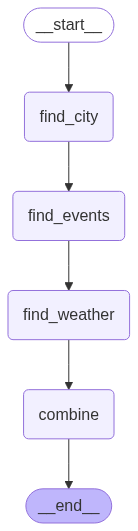

In [20]:
from IPython.display import display, Image

# This generates a PNG image of the graph using Mermaid rendering
png_data = multi_agent_graph.get_graph().draw_mermaid_png()

# Display inline in Jupyter notebook / IPython environment
display(Image(png_data))


### Test the agents
- LangGraph expects the input state according to the State type, so pass as dict

In [21]:
initial_state = {"user_query": "Find events and weather in San Francisco."}

final_state = multi_agent_graph.invoke(initial_state)

print("Final recommendation:")
print(final_state.get("recommendation", "No recommendation generated."))


Final recommendation:
The weather in San Francisco will be sunny with a high of 30°C.
